## Bag of Visual Words
- Visual Feature Detection
- Visual Feature Representation
- Codebook Generation  
  (본 예제에서는 SIFT 활용)
- Similarity Search

In [1]:
import cv2
import numpy as np
from datasets import load_dataset
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
dataset = load_dataset("keremberke/shoe-classification", 'full',split='train')

### SIFT(Scale Invariant Feature Transform)

- 이미지 내 눈에 띄는 고유 지점
- 이미지 스케일과 회전에 불변적인 속성 보유
- 다양한 크기와 각도에서도 동일한 지점을 찾는 것이 가능

In [3]:
def extract_sift_features(image):
    '''
    Descriptors
    각 키포인트 주변 영역에 대한 정보를 담은 벡터 representation(128차원)
    키포인트를 형용하는 모습이나 패턴이 담긴 정보로, 주변 픽셀들의 강도 변화를 통해 계산
    '''
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors

In [4]:
image_descriptors = []

for imageset in dataset:
    image = np.array(imageset['image'])
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # SIFT는 grayscale만 사용
    descriptors = extract_sift_features(gray_image)

    if descriptors is not None:
        descriptors = descriptors.astype(np.float32)
        image_descriptors.append(descriptors)
    else:
        image_descriptors.append(np.zeros((1, 128), dtype=np.float32))

# KMeans 클러스터링을 위한 SIFT 벡터 Vertical Stack
all_descriptors = np.vstack([desc for desc in image_descriptors if desc is not None])

num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(all_descriptors)

def image_to_histogram(image_desc):
    labels = kmeans.predict(image_desc)
    hist, _ = np.histogram(labels, bins=np.arange(num_clusters+1), density=True)
    return hist
image_histograms = [image_to_histogram(desc) for desc in image_descriptors]


In [5]:
image_histograms[50]

array([0.06896552, 0.18103448, 0.07758621, 0.21551724, 0.04741379,
       0.09482759, 0.06034483, 0.13793103, 0.09051724, 0.02586207])

In [6]:
def extract_and_draw_keypoints_quantized(image, kmeans_model):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    if descriptors is None:
        return image

    descriptors = descriptors.astype(np.float32)
    labels = kmeans_model.predict(descriptors)

    output_image = image.copy()
    for keypoint, label in zip(keypoints, labels):
        color = plt.cm.get_cmap('hsv', num_clusters)(label)
        color = tuple([int(x * 255) for x in color[:3]])
        x, y = keypoint.pt
        cv2.circle(output_image, (int(x), int(y)), 3, color, -1)

    return output_image

def extract_and_draw_keypoints(image):
    if not isinstance(image, np.ndarray):
        image = np.array(image)

    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    keypoints, _ = sift.detectAndCompute(gray_image, None)
    keypoint_image = cv2.drawKeypoints(image, keypoints, None)
    return keypoint_image

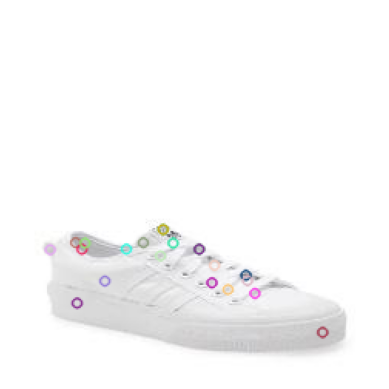

In [7]:
#생성된 SIFT VECTOR의 Keypoints 확인
query_img_with_keypoints = extract_and_draw_keypoints(dataset[0]['image'])
plt.imshow(query_img_with_keypoints)
plt.axis('off')
plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10760\2227425315.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('hsv', num_clusters)(label)


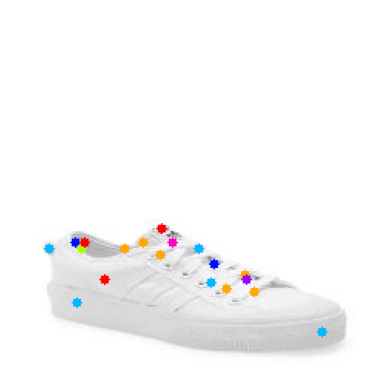

In [8]:
#생성된 SIFT VECTOR의 Quantized Keypoints 확인
colored_keypoints_image = extract_and_draw_keypoints_quantized(np.array(dataset[0]['image']), kmeans)
plt.imshow(colored_keypoints_image)
plt.axis('off')
plt.show()

In [9]:
#이미지 검색 (CBIR)
def retrieve_images(query_idx, histograms, top_k=3):
    query_hist = histograms[query_idx]
    similarities = [cosine_similarity(query_hist.reshape(1, -1), hist.reshape(1, -1))[0][0] for hist in histograms]

    # 쿼링 이미지 제외 나머지 이미지들에 대해 일괄적으로 코사인 유사도 기준 소팅
    similarities = [(idx, sim) for idx, sim in enumerate(similarities) if idx != query_idx]
    similarities.sort(key=lambda x: x[1], reverse=True)

    # 가장 유사한 이미지와 안비슷한 이미지 추출
    similar_images = [idx for idx, _ in similarities[:top_k]]
    dissimilar_images = [idx for idx, _ in similarities[-top_k:]]

    return similar_images, dissimilar_images

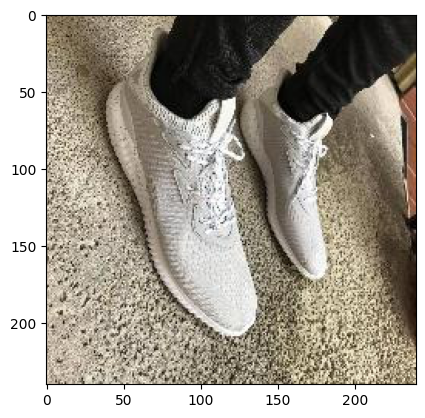

In [10]:
plt.imshow(dataset[65]['image'])

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10760\2227425315.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('hsv', num_clusters)(label)


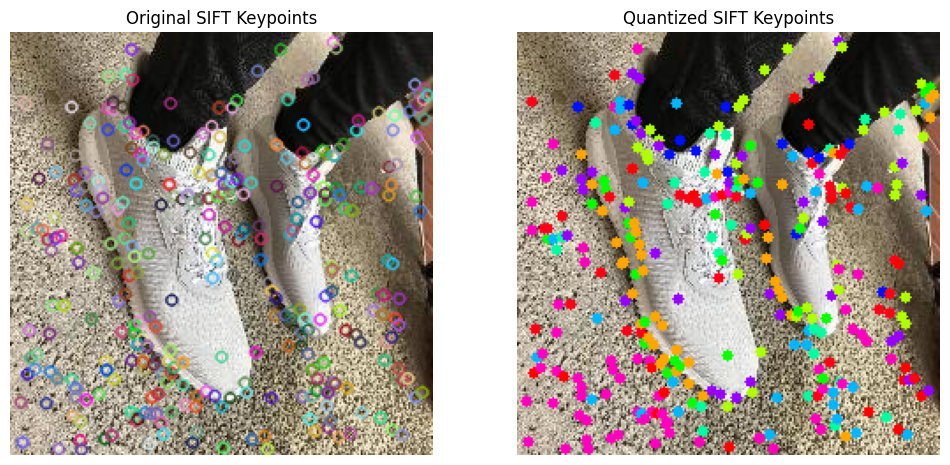

In [11]:
query_idx = 65
similar_images, dissimilar_images = retrieve_images(query_idx, image_histograms)
#생성된 SIFT VECTOR의 keypoints 확인
query_img_with_keypoints = extract_and_draw_keypoints(dataset[query_idx]['image'])
colored_keypoints_image = extract_and_draw_keypoints_quantized(np.array(dataset[query_idx]['image']), kmeans)
plt.figure(figsize=(12, 6))

# Original keypoints
plt.subplot(1, 2, 1)
plt.imshow(query_img_with_keypoints)
plt.title('Original SIFT Keypoints')
plt.axis('off')

# Quantized keypoints
plt.subplot(1, 2, 2)
plt.imshow(colored_keypoints_image)
plt.title('Quantized SIFT Keypoints')
plt.axis('off')

plt.show() ## keypoint 줄이는 것 가능

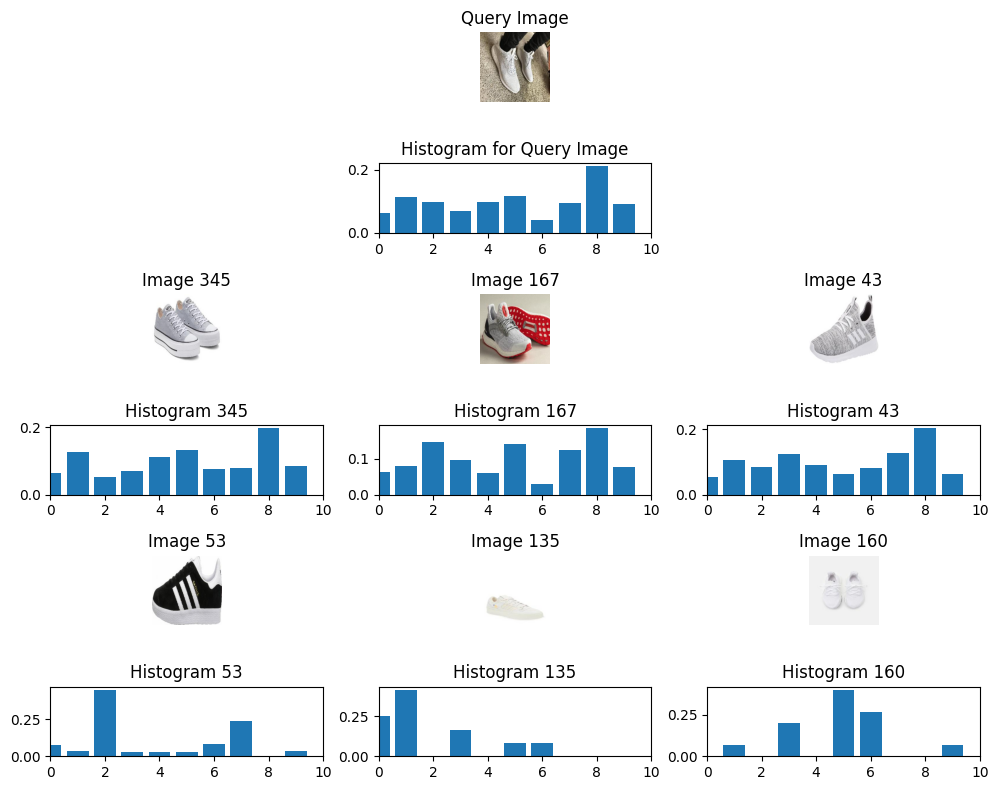

In [12]:
def display_row_of_images_and_histograms(image_indices, row, gs, num_bins):
    for i, idx in enumerate(image_indices):
        ax_img = plt.subplot(gs[row, i])
        ax_img.imshow(dataset[idx]['image'])
        ax_img.set_title(f'Image {idx}')
        ax_img.axis('off')

        ax_hist = plt.subplot(gs[row + 1, i])
        ax_hist.bar(range(num_bins), image_histograms[idx])
        ax_hist.set_title(f'Histogram {idx}')
        ax_hist.set_xlim([0, num_bins])

plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(6, 3)

plt.subplot(gs[0, :])
plt.imshow(dataset[query_idx]['image'])
plt.title('Query Image')
plt.axis('off')

plt.subplot(gs[1, 1])
plt.bar(range(num_clusters), image_histograms[query_idx])
plt.title('Histogram for Query Image')
plt.xlim([0, num_clusters])

display_row_of_images_and_histograms(similar_images, 2, gs, num_clusters)

display_row_of_images_and_histograms(dissimilar_images, 4, gs, num_clusters)

plt.tight_layout()
plt.show()

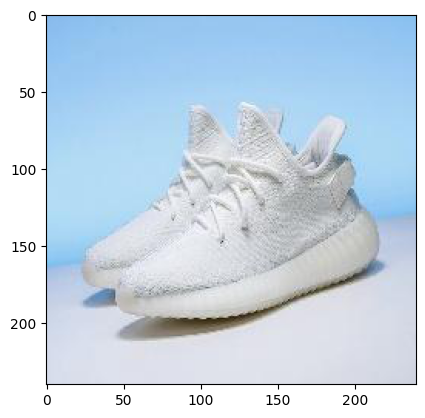

In [13]:
plt.imshow(dataset[94]['image'])

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10760\2227425315.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('hsv', num_clusters)(label)


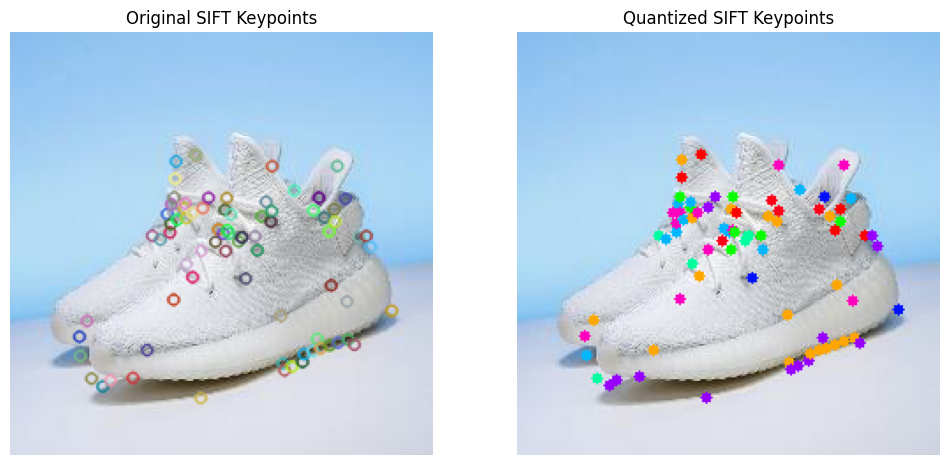

In [14]:
query_idx = 94
similar_images, dissimilar_images = retrieve_images(query_idx, image_histograms)
#생성된 SIFT VECTOR의 keypoints 확인
query_img_with_keypoints = extract_and_draw_keypoints(dataset[query_idx]['image'])
colored_keypoints_image = extract_and_draw_keypoints_quantized(np.array(dataset[query_idx]['image']), kmeans)
plt.figure(figsize=(12, 6))

# Original keypoints
plt.subplot(1, 2, 1)

plt.imshow(query_img_with_keypoints)
plt.title('Original SIFT Keypoints')
plt.axis('off')

# Quantized keypoints
plt.subplot(1, 2, 2)

plt.imshow(colored_keypoints_image)
plt.title('Quantized SIFT Keypoints')
plt.axis('off')

plt.show()

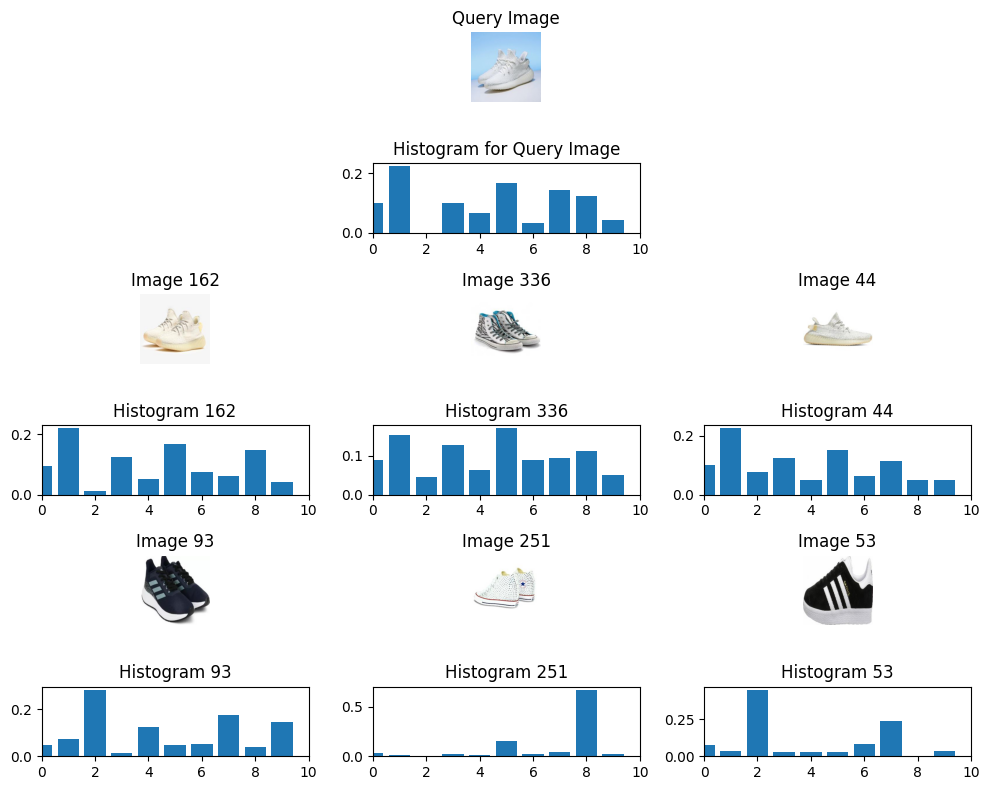

In [15]:
def display_row_of_images_and_histograms(image_indices, row, gs, num_bins):
    for i, idx in enumerate(image_indices):
        ax_img = plt.subplot(gs[row, i])
        ax_img.imshow(dataset[idx]['image'])
        ax_img.set_title(f'Image {idx}')
        ax_img.axis('off')

        ax_hist = plt.subplot(gs[row + 1, i])
        ax_hist.bar(range(num_bins), image_histograms[idx])
        ax_hist.set_title(f'Histogram {idx}')
        ax_hist.set_xlim([0, num_bins])

plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(6, 3)

plt.subplot(gs[0, :])
plt.imshow(dataset[query_idx]['image'])
plt.title('Query Image')
plt.axis('off')

plt.subplot(gs[1, 1])
plt.bar(range(num_clusters), image_histograms[query_idx])
plt.title('Histogram for Query Image')
plt.xlim([0, num_clusters])

display_row_of_images_and_histograms(similar_images, 2, gs, num_clusters)

display_row_of_images_and_histograms(dissimilar_images, 4, gs, num_clusters)

plt.tight_layout()
plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10760\2227425315.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('hsv', num_clusters)(label)


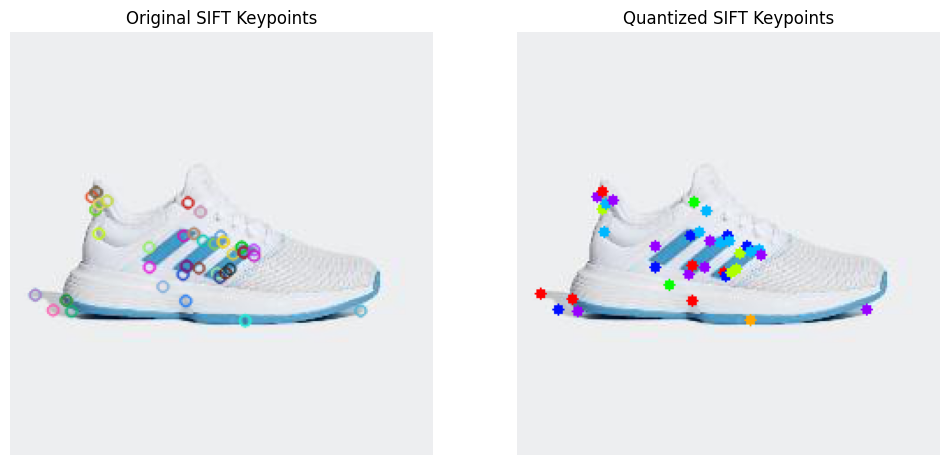

In [16]:
query_idx = 155
similar_images, dissimilar_images = retrieve_images(query_idx, image_histograms)
#생성된 SIFT VECTOR의 keypoints 확인
query_img_with_keypoints = extract_and_draw_keypoints(dataset[query_idx]['image'])
colored_keypoints_image = extract_and_draw_keypoints_quantized(np.array(dataset[query_idx]['image']), kmeans)
plt.figure(figsize=(12, 6))

# Original keypoints
plt.subplot(1, 2, 1)

plt.imshow(query_img_with_keypoints)
plt.title('Original SIFT Keypoints')
plt.axis('off')

# Quantized keypoints
plt.subplot(1, 2, 2)

plt.imshow(colored_keypoints_image)
plt.title('Quantized SIFT Keypoints')
plt.axis('off')

plt.show()

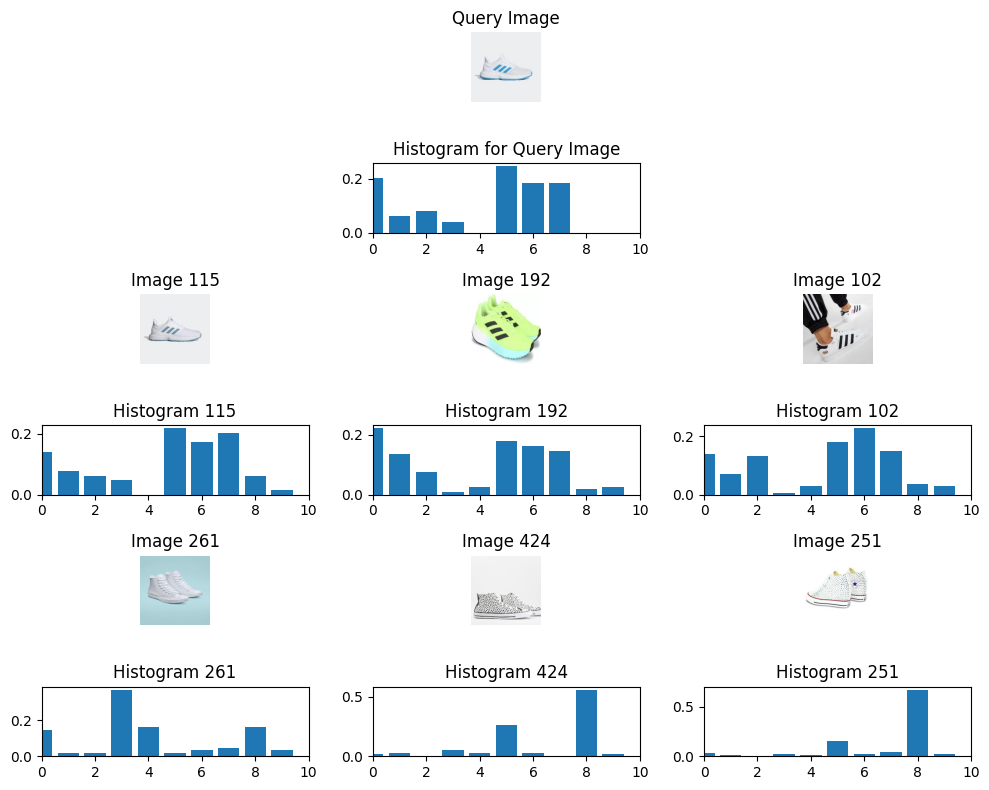

In [17]:

plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(6, 3)

plt.subplot(gs[0, :])
plt.imshow(dataset[query_idx]['image'])
plt.title('Query Image')
plt.axis('off')

plt.subplot(gs[1, 1])
plt.bar(range(num_clusters), image_histograms[query_idx])
plt.title('Histogram for Query Image')
plt.xlim([0, num_clusters])

display_row_of_images_and_histograms(similar_images, 2, gs, num_clusters)

display_row_of_images_and_histograms(dissimilar_images, 4, gs, num_clusters)

plt.tight_layout()
plt.show()